# CUADERNO EVALUACIÓN PERCEPTUAL
Se van a ejecutar los dos mejores modelos. Se utilizarán las 6 frases de la evaluación perceptal. Habrá un total de 12 frases, 2 por cada frase de test.

In [1]:
import json
import nemo
import torch
import librosa
import numpy as np
import random

from pathlib import Path
from tqdm.notebook import tqdm

import IPython.display as ipd
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

import librosa
import soundfile as sf

[NeMo W 2023-09-11 17:18:08 optimizers:66] Could not import distributed_fused_adam optimizer from Apex
[NeMo W 2023-09-11 17:18:09 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-11 17:18:09 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-11 17:18:09 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-11 17:18:09 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-11

In [106]:
###############################AUDIOS EVALUACIÓN PERCEPTAL################################
##Test Frase 1
# test= "Miss Robert, las zapatillas color: blanco, talla: 11, referencia: 501-97-52, precio: 319 francos, se le entregarán en 1 semana."
##Frase 2
# test= "Sr. Johnson, el televisor multiestándar con mando a distancia, pantalla de 36 cm, referencia: 811-61-32, precio: 2 492 francos, le será entregado en 3 semanas."
##Frase 3
# test= "Sr. Moore, el taladro eléctrico D162, potencia: 550 vatios, 2 velocidades, referencia: 481-20-30, precio: 499 francos, se le entregará en 2 semanas."
##Frase 4
# test="El tren número 9783 procedente de Glasgow llegará a las 9:24, andén número 3, vía ge."
##Frase 5
# test="El tren número 7826 a Ipswich saldrá a las 12:20, andén número 9, vía a'."
##Frase 6
test="El tren número 4320 procedente de Birmingham llegará a las 5:44, andén 2, vía ce"
##########################################################################################
test_id = "19demarzo_3270" # identifier for the audio corresponding to the test text
data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/" # path to dataset folder with wav files from original dataset

In [107]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test, speaker=None):
    seed = random.randint(100000, 999999)
#   print(seed)
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        if speaker == None:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        else:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

# MEJOR MODELO FASTPITCH

In [108]:
#Audios 19demarzo modelo entrenado desde 0.
# import glob, os
# lista = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_08*/checkpoints/*.ckpt")
# for le in sorted(lista, key=os.path.basename):
#     print(os.path.dirname(le),"\n\t",os.path.basename(le))
# print(sorted(lista, key=os.path.basename)[0])

#Audios profe Segovia con modelo finetuning
import glob, os
lista = glob.glob("/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints/*.ckpt")
# lista = glob.glob("/home/irene/datasets/NemoSpanishTTSEsMapa152Finetuning/resultSpanishTTS/FastPitch/2023-08-04_13-29-05/checkpoints/*.ckpt")

for le in sorted(lista, key=os.path.basename):
    print(os.path.dirname(le),"\n\t",os.path.basename(le))
print(sorted(lista, key=os.path.basename)[0])

/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints 
	 FastPitch--val_loss=1.3989-epoch=65.ckpt
/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints 
	 FastPitch--val_loss=1.4101-epoch=87.ckpt
/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints 
	 FastPitch--val_loss=1.4560-epoch=54.ckpt
/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints 
	 FastPitch--val_loss=1.7625-epoch=691-last.ckpt
/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-19_12-14-40/checkpoints/FastPitch--val_loss=1.3989-epoch=65.ckpt


In [109]:
hfg_ngc = "tts_en_lj_hifigan_ft_mixerttsx" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_lj_hifigan
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()

[NeMo I 2023-09-10 14:50:03 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.
[NeMo I 2023-09-10 14:50:03 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo
[NeMo I 2023-09-10 14:50:03 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-09-10 14:50:05 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_train.json
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 1
    
[NeMo W 2023-09-10 14:50:05 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_val.json
      min_duration: 3
      n_segments: 66048
    dataloader_params:
      drop_last: false


[NeMo I 2023-09-10 14:50:05 features:291] PADDING: 0
[NeMo I 2023-09-10 14:50:05 features:299] STFT using exact pad
[NeMo I 2023-09-10 14:50:05 features:291] PADDING: 0
[NeMo I 2023-09-10 14:50:05 features:299] STFT using exact pad
[NeMo I 2023-09-10 14:50:06 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.


In [110]:
#Modelo Finetuned FastPitch con dataset nuevo 2
import glob, os

file_list = glob.glob("/home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-20_11-02-23/checkpoints/FastPitch--val_loss=1.5916-epoch=58.ckpt")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[0] # path_to_fastpitch_nemo_or_ckpt
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(fastpitch_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(fastpitch_model_path))

if ".nemo" in fastpitch_model_path:
    spec_gen_model_Finetuned_FastPitch_2 = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model_Finetuned_FastPitch_2 = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  FastPitch--val_loss=1.5916-epoch=58.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTSFinetuning/resultSpanishTTS/FastPitch/2023-07-20_11-02-23/checkpoints


[NeMo W 2023-09-10 14:51:26 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 109.04179382324219
      pitch_std: 25.54973793029785
    dataloader_params:
      drop_last: false
    

[NeMo I 2023-09-10 14:51:26 features:291] PADDING: 1


original audio


torch.Size([1, 80, 512])


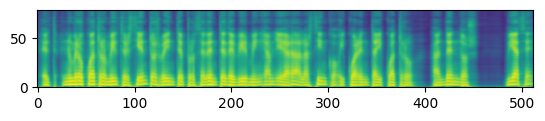

Modelo Finetuned FastPitch 2:


In [111]:
%matplotlib inline

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))

#Modelo mejor 2
audio_modelo_Finetuned_FastPitch_2, spectrogram_Finetuned_FastPitch_2 = evaluate_spec_fastpitch_ckpt(spec_gen_model_Finetuned_FastPitch_2, vocoder_model, test)

# visualize the spectrogram
if spectrogram_Finetuned_FastPitch_2 is not None:
    imshow(spectrogram_Finetuned_FastPitch_2, origin="lower")
    plt.show()
print("Modelo Finetuned FastPitch 2:")
ipd.display(ipd.Audio(audio_modelo_Finetuned_FastPitch_2, rate=22050))


In [112]:
!mkdir muestrasEvaluaciónPerceptal

mkdir: cannot create directory ‘muestrasEvaluaciónPerceptal’: File exists


In [113]:
sf.write('muestrasEvaluaciónPerceptal/audio_modelo_Finetuned_FastPitch_2_Audio_6.wav', audio_modelo_Finetuned_FastPitch_2, 22050)

# MEJOR MODELO HIFIGAN

In [114]:
# load best fastpich model
import glob, os
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints/FastPitch--val_loss=0.7140-epoch=265.ckpt")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[0] # path_to_fastpitch_nemo_or_ckpt
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(fastpitch_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(fastpitch_model_path))

if ".nemo" in fastpitch_model_path:
    spec_gen_model_1 = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model_1 = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  FastPitch--val_loss=0.7140-epoch=265.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints


[NeMo W 2023-09-10 14:52:50 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 126.73465728759766
      pitch_std: 38.099849700927734
    dataloader_params:
      drop_last: false
   

[NeMo I 2023-09-10 14:52:50 features:291] PADDING: 1


In [115]:
#Modelo 3 HifIGAN
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_18-20-28/checkpoints/HifiGan--val_loss=0.9774-epoch=1.ckpt")
hifigan_model_path = sorted(file_list, key=os.path.basename)[0]
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(hifigan_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(hifigan_model_path))
vocoder_model_3 = HifiGanModel.load_from_checkpoint(checkpoint_path=hifigan_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  HifiGan--val_loss=0.9774-epoch=1.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_18-20-28/checkpoints


[NeMo W 2023-09-10 14:52:50 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: train_manifest_text_normed_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2023-09-10 14:52:50 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.Vo

[NeMo I 2023-09-10 14:52:50 features:291] PADDING: 0
[NeMo I 2023-09-10 14:52:50 features:299] STFT using exact pad
[NeMo I 2023-09-10 14:52:50 features:291] PADDING: 0
[NeMo I 2023-09-10 14:52:50 features:299] STFT using exact pad


In [116]:
audio_3, spectrogram_3 = evaluate_spec_fastpitch_ckpt(spec_gen_model_1, vocoder_model_3, test)

torch.Size([1, 80, 577])


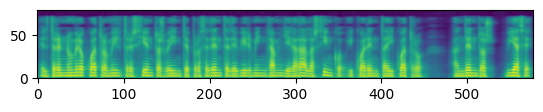

Modelo 3 Finetuned HiFiGAN


In [117]:
# visualize the spectrogram
if spectrogram_3 is not None:
    imshow(spectrogram_3, origin="lower")
    plt.show()
print("Modelo 3 Finetuned HiFiGAN")
ipd.display(ipd.Audio(audio_3, rate=22050))

In [118]:
sf.write('muestrasEvaluaciónPerceptal/audio_modelo_Finetuned_HifiGAN_3_Audio_6.wav', audio_3, 22050)